In [83]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from scipy.optimize import minimize
import scipy.stats
# import sklearn.mixture as sm
from scipy.special import logsumexp
import emcee
import pickle

# import myutils
from pyia import GaiaData
import gala.dynamics as gd
import gala.potential as gp

In [84]:
plt.style.use('notebook')

In [3]:
R = np.load('../data/jhelum_rotmat_init.npy')

In [4]:
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [5]:
wangle = 180*u.deg

In [6]:
ham_pw = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), 
                                          halo=dict(c=0.95, m=7E11),
                                          bulge=dict(m=4E9),
                                          disk=dict(m=5.5e10)))
ham_bovy = gp.Hamiltonian(gp.BovyMWPotential2014())
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)

In [7]:
pos_pw = np.load('../data/jhelum_orbit_narrow.npy')
pos_bovy = np.load('../data/jhelum_orbit_narrow_mwpotential2014.npy')
# pos = np.load('../data/jhelum_orbit.npy')

In [8]:
dt = 0.5*u.Myr
positions = [pos_pw, pos_bovy]
potentials = [ham_pw, ham_bovy]
fit_orbits = []
model_streams = []
fwd_orbits = []
fwd_models = []
rr_orbits = []
rr_models = []
titles = ['Price-Whelan (2017)', 'Bovy (2014)']

for i in range(2):
    phi1, phi2, d, pm1, pm2, vr = positions[i]
    ham = potentials[i]

    c_ = Jhelum(phi1=phi1*u.deg, phi2=phi2*u.deg, distance=d*u.kpc, 
               pm_phi1_cosphi2=pm1*u.mas/u.yr,
               pm_phi2=pm2*u.mas/u.yr,
               radial_velocity=vr*u.km/u.s)
    w0 = gd.PhaseSpacePosition(c_.transform_to(gc_frame).cartesian)

    fit_orbit = ham.integrate_orbit(w0, dt=dt, n_steps=38)
    model_jhelum = fit_orbit.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)

    orbit_fwd = ham.integrate_orbit(w0, dt=0.5, t1=0*u.Myr, t2=7000*u.Myr)
    model_fwd = orbit_fwd.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)

    orbit_rr = ham.integrate_orbit(w0, dt=-0.5, t1=0*u.Myr, t2=-5000*u.Myr)
    model_rr = orbit_rr.to_coord_frame(Jhelum, galactocentric_frame=gc_frame)
    
    # store
    fit_orbits += [fit_orbit]
    model_streams += [model_jhelum]
    fwd_orbits += [orbit_fwd]
    fwd_models += [model_fwd]
    rr_orbits += [orbit_rr]
    rr_models += [model_rr]

In [9]:
import gala.coordinates as gc

In [10]:
# Indus
ra_ind = np.array([-36.3, -8])*u.deg
dec_ind = np.array([-50.7, -64.8])*u.deg
d_ind = np.array([16.6, 17.1])*u.kpc

cind = coord.SkyCoord(ra=ra_ind, dec=dec_ind, distance=d_ind, frame='icrs')
cind_gal = cind.transform_to(coord.Galactocentric)
Rind = np.sqrt(cind_gal.y**2 + cind_gal.x**2)

In [11]:
indus_frame = gc.GreatCircleICRSFrame.from_endpoints(cind[0], cind[1])
cind_nat = cind.transform_to(indus_frame)

In [46]:
cind_line_far = coord.SkyCoord(phi1=np.linspace(cind_nat.phi1.wrap_at(wangle)[0], 
                                            cind_nat.phi1.wrap_at(wangle)[1],20),
                       phi2=np.zeros(20)*u.deg, distance=np.linspace(16.6,17.2,20)*u.kpc, frame=indus_frame)

In [47]:
cind_line_far_gal = cind_line_far.transform_to(coord.Galactocentric)
Rind_line_far = np.sqrt(cind_line_far_gal.y**2 + cind_line_far_gal.x**2)

In [13]:
cind_line = coord.SkyCoord(phi1=np.linspace(cind_nat.phi1.wrap_at(wangle)[0], 
                                            cind_nat.phi1.wrap_at(wangle)[1],20),
                       phi2=np.zeros(20)*u.deg, distance=np.linspace(14.6,15.2,20)*u.kpc, frame=indus_frame)

In [14]:
cind_line_gal = cind_line.transform_to(coord.Galactocentric)
Rind_line = np.sqrt(cind_line_gal.y**2 + cind_line_gal.x**2)

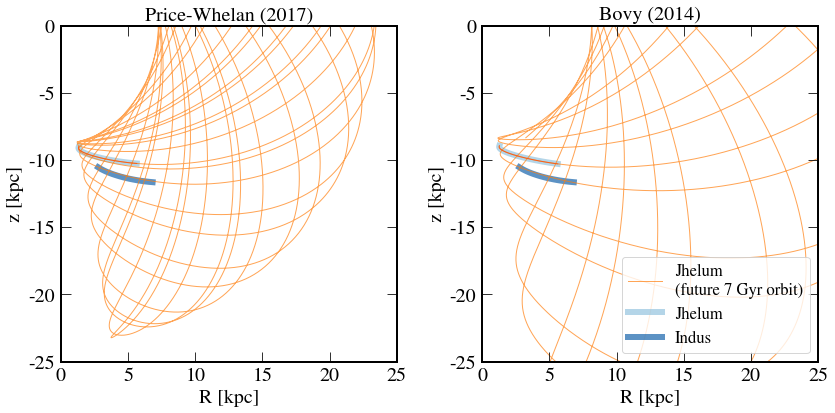

In [65]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
color = 'orangered'

for i in range(2):
    plt.sca(ax[i])

#     plt.plot(rr_orbits[i].cylindrical.rho, rr_orbits[i].cylindrical.z, '-', color=color, alpha=0.7, lw=1, 
#              label='Jhelum\n(past 5 Gyr orbit)', zorder=1)
    plt.plot(fwd_orbits[i].cylindrical.rho, fwd_orbits[i].cylindrical.z, '-', color='tab:orange', alpha=0.7, lw=1, 
             label='Jhelum\n(future 7 Gyr orbit)', zorder=1)
    plt.plot(fit_orbits[i].cylindrical.rho, fit_orbits[i].cylindrical.z, '-', color=mpl.cm.Blues(0.4),
             alpha=0.7, lw=6, label='Jhelum', zorder=0)
    plt.plot(Rind_line, cind_line_gal.z, '-', label='Indus', lw=6, alpha=0.7, color=mpl.cm.Blues(0.8), zorder=0)
    plt.plot(fit_orbits[i].cylindrical.rho, fit_orbits[i].cylindrical.z, '-', color=color, alpha=0.7, lw=1, label='')

    plt.xlim(0,25)
    plt.ylim(-25,0)
    plt.gca().set_aspect('equal')
    plt.title(titles[i], fontsize='medium')
    plt.xlabel('R [kpc]')
    plt.ylabel('z [kpc]')

plt.sca(ax[1])
plt.legend(loc=4, fontsize='small', framealpha=0.8)
plt.tight_layout()

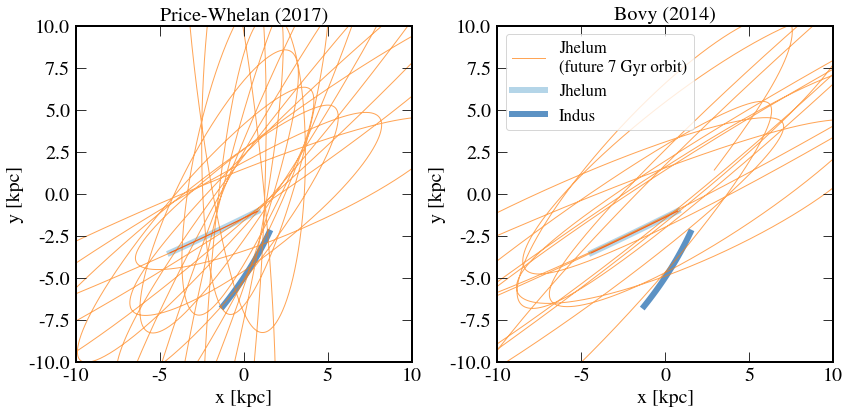

In [70]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
color = 'orangered'

for i in range(2):
    plt.sca(ax[i])

#     plt.plot(rr_orbits[i].cartesian.x, rr_orbits[i].cartesian.y, '-', color=color, alpha=0.7, lw=1, 
#              label='Jhelum\n(past 5 Gyr orbit)', zorder=1)
    plt.plot(fwd_orbits[i].cartesian.x, fwd_orbits[i].cartesian.y, '-', color='tab:orange', alpha=0.7, lw=1, 
             label='Jhelum\n(future 7 Gyr orbit)', zorder=1)
    plt.plot(fit_orbits[i].cartesian.x, fit_orbits[i].cartesian.y, '-', color=mpl.cm.Blues(0.4),
             alpha=0.7, lw=6, label='Jhelum', zorder=0)
    plt.plot(cind_line_gal.x, cind_line_gal.y, '-', label='Indus', lw=6, alpha=0.7, color=mpl.cm.Blues(0.8),
             zorder=0)
    plt.plot(fit_orbits[i].cartesian.x, fit_orbits[i].cartesian.y, '-', color=color, alpha=0.7, lw=1, label='')

    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.gca().set_aspect('equal')
    plt.title(titles[i], fontsize='medium')
    plt.xlabel('x [kpc]')
    plt.ylabel('y [kpc]')

plt.legend(loc=2, fontsize='small', framealpha=0.8)
plt.tight_layout()

### Load the data

In [85]:
pkl = pickle.load(open('../data/members_coord.pkl', 'rb'))
cj = pkl['c']

In [86]:
def jhelum_dist(phi1, d0=12.8, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p2-p1)
    return (m*(phi1.wrap_at(wangle).value - p1) + d1) * u.kpc

In [88]:
model_jhelum = fit_orbits[0].to_coord_frame(Jhelum, galactocentric_frame=gc_frame)

In [89]:
i1 = np.argmin(np.abs(model_jhelum.phi1.wrap_at(wangle)))
i2 = np.argmin(np.abs(model_jhelum.phi1.wrap_at(wangle)-20*u.deg))
d1, d2 = model_jhelum.distance[i1].value, model_jhelum.distance[i2].value

print(d1, d2)

11.48661281657148 12.307237747487664


In [91]:
# adopt distance gradient from the model
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1, d1=d1, d2=d2),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [92]:
cgal = cj_dist.transform_to(coord.Galactocentric)
R = np.sqrt(cgal.y**2 + cgal.x**2)

## Paper figure

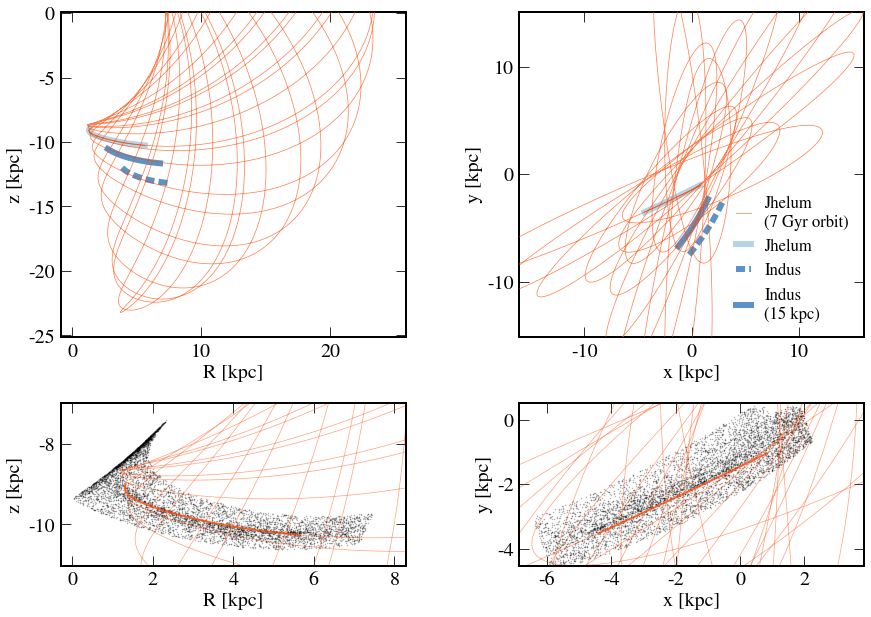

In [111]:
color = 'orangered'

fig, ax = plt.subplots(2,2,figsize=(12.5,9), subplot_kw={'adjustable': 'datalim'}, 
                       gridspec_kw={'height_ratios': (2,1)})

plt.sca(ax[0][0])
# plt.plot(rr_orbits[0].cylindrical.rho, rr_orbits[0].cylindrical.z, '-', color=color, alpha=0.7, lw=0.7, zorder=10)
plt.plot(fwd_orbits[0].cylindrical.rho, fwd_orbits[0].cylindrical.z, '-', color=color, alpha=0.7, lw=0.7, zorder=10,
        label='Jhelum\n(7 Gyr orbit)')
plt.plot(fit_orbits[0].cylindrical.rho, fit_orbits[0].cylindrical.z, '-', color=mpl.cm.Blues(0.4),
         alpha=0.7, lw=6, label='Jhelum')
plt.plot(Rind_line_far, cind_line_far_gal.z, '--', label='Indus', lw=6, alpha=0.7, color=mpl.cm.Blues(0.8),
         dashes=(1.5,0.7))
plt.plot(Rind_line, cind_line_gal.z, '-', label='Indus\n(15 kpc)', lw=6, alpha=0.7, color=mpl.cm.Blues(0.8))
plt.plot(fit_orbits[0].cylindrical.rho, fit_orbits[0].cylindrical.z, '-', color=color, alpha=0.7, lw=1, label='')

# plt.legend(loc=4, fontsize='small', frameon=False, handlelength=0.9)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(0,25)
plt.ylim(-25,0)
plt.gca().set_aspect('equal')

plt.sca(ax[1][0])
plt.plot(fwd_orbits[0].cylindrical.rho, fwd_orbits[0].cylindrical.z, '-', color=color, alpha=0.5, lw=0.7)
# plt.plot(orbit_fwd.cylindrical.rho, orbit_fwd.cylindrical.z, '-', color='steelblue', alpha=0.7, lw=1)
plt.plot(fit_orbits[0].cylindrical.rho, fit_orbits[0].cylindrical.z, '-', color=color, alpha=0.7, lw=2)
plt.plot(R, cgal.z, 'k.', ms=1, alpha=0.3, zorder=0, rasterized=True)

plt.gca().set_aspect('equal')
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(0,8)
plt.ylim(-11,-7)


# x-y plane
plt.sca(ax[0][1])
# plt.plot(rr_orbits[0].cartesian.x, rr_orbits[0].cartesian.y, '-', color=color, alpha=0.7, lw=0.7, zorder=10)
plt.plot(fwd_orbits[0].cartesian.x, fwd_orbits[0].cartesian.y, '-', color=color, alpha=0.7, lw=0.7, zorder=10,
        label='Jhelum\n(7 Gyr orbit)')
plt.plot(fit_orbit.cartesian.x, fit_orbit.cartesian.y, '-', color=mpl.cm.Blues(0.4), alpha=0.7, lw=6,
         label='Jhelum')
plt.plot(cind_line_far_gal.x, cind_line_far_gal.y, '--', lw=6, alpha=0.7, color=mpl.cm.Blues(0.8), dashes=(1.5,0.7),
        label='Indus')
plt.plot(cind_line_gal.x, cind_line_gal.y, '-', lw=6, alpha=0.7, color=mpl.cm.Blues(0.8),
         label='Indus\n(15 kpc)')
plt.plot(fit_orbits[0].cartesian.x, fit_orbits[0].cartesian.y, '-', color=color, alpha=0.7, lw=1, label='')

plt.legend(loc=4, fontsize='small', frameon=False, handlelength=0.9)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
plt.gca().set_aspect('equal')

plt.sca(ax[1][1])
# plt.plot(rr_orbits[0].cartesian.x, rr_orbits[0].cartesian.y, '-', color=color, alpha=0.4, lw=0.7)
plt.plot(fwd_orbits[0].cartesian.x, fwd_orbits[0].cartesian.y, '-', color=color, alpha=0.5, lw=0.7)
# plt.plot(orbit_fwd.cylindrical.rho, orbit_fwd.cylindrical.z, '-', color='steelblue', alpha=0.7, lw=1)
plt.plot(fit_orbits[0].cartesian.x, fit_orbits[0].cartesian.y, '-', color=color, alpha=0.7, lw=2)
plt.plot(cgal.x, cgal.y, 'k.', ms=1, alpha=0.3, zorder=0, rasterized=True)

plt.gca().set_aspect('equal')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.xlim(-5.5,2.5)
plt.ylim(-4.5,0.5)
plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))


plt.tight_layout(w_pad=3)
plt.savefig('../paper/orbit.pdf', dpi=200)

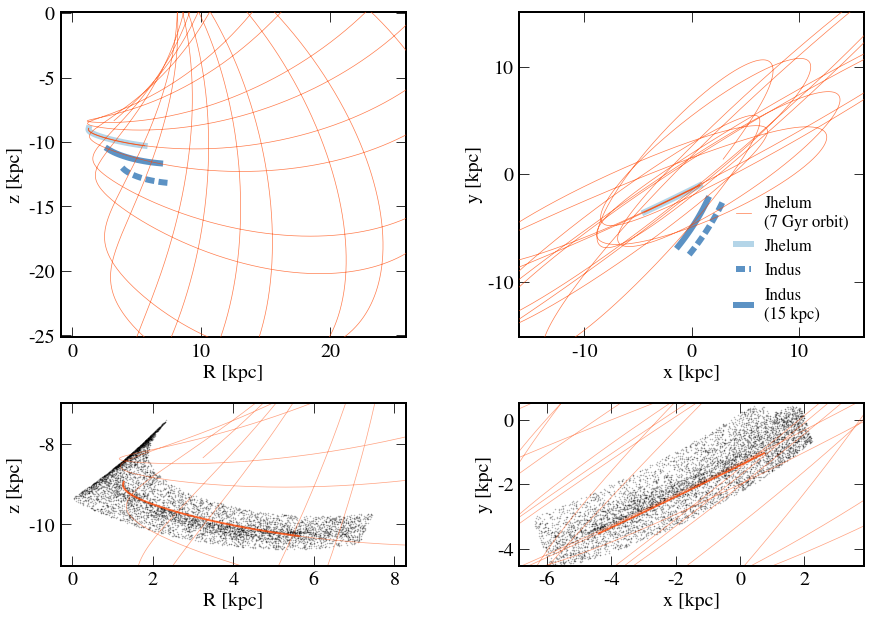

In [110]:
color = 'orangered'

fig, ax = plt.subplots(2,2,figsize=(12.5,9), subplot_kw={'adjustable': 'datalim'}, 
                       gridspec_kw={'height_ratios': (2,1)})

plt.sca(ax[0][0])
# plt.plot(rr_orbits[1].cylindrical.rho, rr_orbits[1].cylindrical.z, '-', color=color, alpha=0.7, lw=0.7, zorder=10)
plt.plot(fwd_orbits[1].cylindrical.rho, fwd_orbits[1].cylindrical.z, '-', color=color, alpha=0.7, lw=0.7, zorder=10,
        label='Jhelum\n(7 Gyr orbit)')
plt.plot(fit_orbits[1].cylindrical.rho, fit_orbits[1].cylindrical.z, '-', color=mpl.cm.Blues(0.4),
         alpha=0.7, lw=6, label='Jhelum')
plt.plot(Rind_line_far, cind_line_far_gal.z, '--', label='Indus', lw=6, alpha=0.7, color=mpl.cm.Blues(0.8),
         dashes=(1.5,0.7))
plt.plot(Rind_line, cind_line_gal.z, '-', label='Indus\n(15 kpc)', lw=6, alpha=0.7, color=mpl.cm.Blues(0.8))
plt.plot(fit_orbits[1].cylindrical.rho, fit_orbits[1].cylindrical.z, '-', color=color, alpha=0.7, lw=1, label='')

# plt.legend(loc=4, fontsize='small', frameon=False, handlelength=0.9)
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(0,25)
plt.ylim(-25,0)
plt.gca().set_aspect('equal')

plt.sca(ax[1][0])
plt.plot(fwd_orbits[1].cylindrical.rho, fwd_orbits[1].cylindrical.z, '-', color=color, alpha=0.5, lw=0.7)
# plt.plot(orbit_fwd.cylindrical.rho, orbit_fwd.cylindrical.z, '-', color='steelblue', alpha=0.7, lw=1)
plt.plot(fit_orbits[1].cylindrical.rho, fit_orbits[1].cylindrical.z, '-', color=color, alpha=0.7, lw=2)
plt.plot(R, cgal.z, 'k.', ms=1, alpha=0.3, zorder=0, rasterized=True)

plt.gca().set_aspect('equal')
plt.xlabel('R [kpc]')
plt.ylabel('z [kpc]')
plt.xlim(0,8)
plt.ylim(-11,-7)


# x-y plane
plt.sca(ax[0][1])
# plt.plot(rr_orbits[1].cartesian.x, rr_orbits[1].cartesian.y, '-', color=color, alpha=0.7, lw=0.7, zorder=10)
plt.plot(fwd_orbits[1].cartesian.x, fwd_orbits[1].cartesian.y, '-', color=color, alpha=0.7, lw=0.7, zorder=10,
        label='Jhelum\n(7 Gyr orbit)')
plt.plot(fit_orbits[1].cartesian.x, fit_orbits[1].cartesian.y, '-', color=mpl.cm.Blues(0.4), alpha=0.7, lw=6,
         label='Jhelum')
plt.plot(cind_line_far_gal.x, cind_line_far_gal.y, '--', lw=6, alpha=0.7, color=mpl.cm.Blues(0.8), dashes=(1.5,0.7),
         label='Indus')
plt.plot(cind_line_gal.x, cind_line_gal.y, '-', lw=6, alpha=0.7, color=mpl.cm.Blues(0.8),
        label='Indus\n(15 kpc)')
plt.plot(fit_orbits[1].cartesian.x, fit_orbits[1].cartesian.y, '-', color=color, alpha=0.7, lw=1, label='')

plt.legend(loc=4, fontsize='small', frameon=False, handlelength=0.9)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
plt.gca().set_aspect('equal')

plt.sca(ax[1][1])
# plt.plot(rr_orbits[1].cartesian.x, rr_orbits[1].cartesian.y, '-', color=color, alpha=0.4, lw=0.7)
plt.plot(fwd_orbits[1].cartesian.x, fwd_orbits[1].cartesian.y, '-', color=color, alpha=0.5, lw=0.7)
# plt.plot(orbit_fwd.cylindrical.rho, orbit_fwd.cylindrical.z, '-', color='steelblue', alpha=0.7, lw=1)
plt.plot(fit_orbits[1].cartesian.x, fit_orbits[1].cartesian.y, '-', color=color, alpha=0.7, lw=2)
plt.plot(cgal.x, cgal.y, 'k.', ms=1, alpha=0.3, zorder=0, rasterized=True)

plt.gca().set_aspect('equal')
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.xlim(-5.5,2.5)
plt.ylim(-4.5,0.5)
plt.gca().xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))


plt.tight_layout(w_pad=3)
plt.savefig('../paper/orbit_mwpotential2014.pdf', dpi=200)